<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/ppf_bis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 약물 효과 예측 인공지능 모델 실습
프로포폴, 레미펜타닐 투여 후 마취 심도(bispectral index) 예측 모델

## VitalDB 데이터 셋 이용
본 예제에서는 오픈 생체 신호 데이터셋인 VitalDB를 이용하는 모든 사용자는 반드시 아래 Data Use Agreement에 동의하여야 합니다.

https://vitaldb.net/data-bank/?query=guide&documentId=13qqajnNZzkN7NZ9aXnaQ-47NWy7kx-a6gbrcEsi-gak&sectionId=h.usmoena3l4rb

동의하지 않을 경우 이 창을 닫으세요.

## 본 프로그램에서 이용할 라이브러리 설치 및 import

In [1]:
!pip install vitaldb

import vitaldb
import numpy as np
import pandas as pd

     |████████████████████████████████| 48 kB 3.7 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 1.1 MB 41.8 MB/s 
     |████████████████████████████████| 132 kB 54.0 MB/s 
     |████████████████████████████████| 7.7 MB 30.9 MB/s 
     |████████████████████████████████| 192 kB 49.8 MB/s 
     |████████████████████████████████| 271 kB 50.2 MB/s 
     |████████████████████████████████| 160 kB 41.4 MB/s 
     |████████████████████████████████| 127 kB 44.9 MB/s 
  Created wheel for aiobotocore: filename=aiobotocore-1.4.2-py3-none-any.whl size=49925 sha256=07938eafc70f00dd88beb9191c81f0aacdf28533c8fc94691a1ea9b1c966a70a
  Stored in directory: /root/.cache/pip/wheels/33/e7/d9/b297a9aa9c43d56bc2463e6e2771655ff638f30b30f0b61fcb
Successfully built aiobotocore
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency r

# Data loading

VitalDB Web API를 통해 데이터 로딩


In [3]:
df_trks = pd.read_csv('https://api.vitaldb.net/trks')
df_cases = pd.read_csv("https://api.vitaldb.net/cases")
df_cases['sex'] = (df_cases['sex'] == 'F').astype(int)  # female은 1으로, male 은 0으로 치환

Case ID 선택(inclusion, exclusion criteria)
- 2시간 이상
- 전신 마취
- 18세 이상
- PPF20_VOL, RFTN20_VOL, PPF20_CE, RFTN20_CE, BIS 트랙이 존재
- 몸무게 35 kg 이상

In [4]:
caseids = list(
  set(df_trks[df_trks['tname'] == 'Orchestra/PPF20_VOL']['caseid']) &
  set(df_trks[df_trks['tname'] == 'Orchestra/RFTN20_VOL']['caseid']) &
  set(df_trks[df_trks['tname'] == 'Orchestra/PPF20_CE']['caseid']) &
  set(df_trks[df_trks['tname'] == 'Orchestra/RFTN20_CE']['caseid']) &
  set(df_trks[df_trks['tname'] == 'BIS/BIS']['caseid']) & 
  set(df_cases[df_cases['age'] > 18]['caseid']) & 
  set(df_cases[df_cases['weight'] > 35]['caseid']) &
  set(df_cases[df_cases['caseend'] > 7200]['caseid']) &
  set(df_cases[df_cases['ane_type'] == 'General']['caseid'])
  )
np.random.shuffle(caseids)

# 데이터 전처리
- dataset을 담을 변수를 설정
- propofol(ppf20), remifentanil(rftn20), bis를 로딩한다
- 기록된 데이터가 짧거나, drug infusion이 실제 없었던 케이스, bis값이 적절하지 않은 케이스는 거르기
- 결측값 및 음수 처리

In [27]:
# vital 파일로부터 dataset 을 만듬
x_ppf_dose = []  # 각 레코드의 프로포폴 주입량
x_rft_dose = []  # 각 레코드의 레미펜타닐 주입량
x_aswh = []  # 각 레코드의 나이, 성별, 키, 몸무게
x_caseid = []  # 각 레코드의 caseid
y = []  # 각 레코드의 출력값 (bis)
y_old = []  # 고전적 모델의 예측값
y_old1 = []  # 고전적 모델의 예측값
y_old2 = []  # 고전적 모델의 예측값

LSTM_TIMEPOINTS = 180
LSTM_NODES = 8
FNN_NODES = 16
BATCH_SIZE = 256  # 한번에 처리할 레코드 수 (GPU 메모리 용량에 따라 결정)
MAX_CASES = 50  # 본 예제에서 사용할 최대 case 수

# 데이터 로딩했을 때 컬럼 순서
PPF_DOSE = 0
RFT_DOSE = 1
PPF_CE = 2
RFT_CE = 3
BIS = 4

icase = 0  # 현재 로딩 중인 케이스 번호
ncase = min(MAX_CASES, len(caseids))
for caseid in caseids:  # 본 연구에 사용할 각 case에 대하여
    print('loading {} ({}/{})'.format(caseid, icase, ncase), end='...', flush=True)

    # 10초 간격 데이터 추출
    vals = vitaldb.load_case(caseid, ['Orchestra/PPF20_VOL', 'Orchestra/RFTN20_VOL', 'Orchestra/PPF20_CE', 'Orchestra/RFTN20_CE', 'BIS/BIS'], 10)

    # 결측값은 측정된 마지막 값으로 대체
    vals = pd.DataFrame(vals).fillna(method='ffill').values
    vals = np.nan_to_num(vals, 0)  # 맨 앞 쪽 결측값은 0으로 대체

    # drug 주입을 하지 않은 case 혹은 bis를 사용하지 않은 case는 제외
    if (np.max(vals, axis=0) <= 1).any():
        print('no drug infusion or bis')
        continue

    # drug infusion 시작 시간을 구하고 그 이전을 삭제
    first_ppf_idx = np.where(vals[:, PPF_DOSE] > 1)[0][0]
    first_rft_idx = np.where(vals[:, RFT_DOSE] > 1)[0][0]
    first_drug_idx = min(first_ppf_idx, first_rft_idx)
    vals = vals[first_drug_idx:, :]

    # volume 을 rate로 변경
    vals[1:, PPF_DOSE] -= vals[:-1, PPF_DOSE]
    vals[1:, RFT_DOSE] -= vals[:-1, RFT_DOSE]
    vals[0, PPF_DOSE] = 0
    vals[0, RFT_DOSE] = 0

    # 음수 값(volume 감소)을 0으로 대체
    vals[vals < 0] = 0

    # bis 값의 첫 값이 80 이하이거나 마지막 값이 70 이하인 case는 사용하지 않음
    valid_bis_idx = np.where(vals[:, BIS] > 0)[0]
    first_bis_idx = valid_bis_idx[0]
    last_bis_idx = valid_bis_idx[-1]
    if vals[first_bis_idx, BIS] < 80:
        print('first bis < 80')
        continue
    if vals[last_bis_idx, BIS] < 70:
        print('last bis < 70')
        continue

    # infusion 시작 전 LSTM_TIMEPOINTS 동안의 dose와 bis를 모두 0으로 세팅
    vals = np.vstack((np.zeros((LSTM_TIMEPOINTS - 1, vals.shape[1])), vals))

    # 현 case의 나이, 성별, 키, 몸무게를 가져옴
    aswh = df_cases.loc[df_cases['caseid'] == caseid, ['age','sex','weight','height']].values.astype(float).flatten()

    # case 시작 부터 종료까지 dataset 에 넣음
    for irow in range(1, vals.shape[0] - LSTM_TIMEPOINTS - 1):
        bis = vals[irow + LSTM_TIMEPOINTS, BIS]
        if bis == 0:
            continue

        # 데이터셋에 입력값을 넣음
        x_ppf_dose.append(vals[irow:irow + LSTM_TIMEPOINTS, PPF_DOSE])
        x_rft_dose.append(vals[irow:irow + LSTM_TIMEPOINTS, RFT_DOSE])

        x_aswh.append(aswh)
        x_caseid.append(caseid)
        y.append(bis)

        ppf_ce = vals[irow + LSTM_TIMEPOINTS, PPF_CE]
        rft_ce = vals[irow + LSTM_TIMEPOINTS, RFT_CE]
        
        u = ppf_ce / 4.47 + rft_ce / 19.3
        g = 1.43

        y_old.append(0.98 * (1 / (1 + u ** g)))

    # 사용할 case
    print('done')
    icase += 1
    if icase >= ncase:
        break


loading 138 (0/50)...done
loading 158 (1/50)...done
loading 284 (2/50)...done
loading 422 (3/50)...done
loading 465 (4/50)...done
loading 765 (5/50)...done
loading 1026 (6/50)...done
loading 1396 (7/50)...done
loading 1657 (8/50)...done
loading 1834 (9/50)...done
loading 1946 (10/50)...done
loading 2014 (11/50)...done
loading 2319 (12/50)...done
loading 2491 (13/50)...done
loading 2809 (14/50)...done
loading 2942 (15/50)...done
loading 2944 (16/50)...done
loading 3275 (17/50)...done
loading 3298 (18/50)...done
loading 3417 (19/50)...done
loading 3462 (20/50)...done
loading 3849 (21/50)...done
loading 3943 (22/50)...done
loading 4050 (23/50)...done
loading 4120 (24/50)...done
loading 4316 (25/50)...done
loading 4366 (26/50)...done
loading 4371 (27/50)...done
loading 4390 (28/50)...done
loading 4395 (29/50)...done
loading 4460 (30/50)...done
loading 4472 (31/50)...done
loading 4540 (32/50)...done
loading 4561 (33/50)...done
loading 4695 (34/50)...done
loading 4879 (35/50)...done
loading 

## 데이터셋 포맷 및 차원 변환

In [28]:
# 입력 데이터셋을 numpy array로 변경
x_ppf_dose = np.array(x_ppf_dose)[..., None]  # LSTM 에 넣기 위해서는 3차원이어야 한다. 마지막 차원을 추가
x_rft_dose = np.array(x_rft_dose)[..., None]
x_aswh = np.array(x_aswh)
y = np.array(y)
y_old = np.array(y_old)
x_caseid = np.array(x_caseid)

# 최종적으로 로딩 된 caseid
caseids = np.unique(x_caseid)

# normalize data
x_aswh = (x_aswh - np.mean(x_aswh, axis=0)) / np.std(x_aswh, axis=0)

# bis 값은 최대값이 98 이므로 98로 나눠 normalization
y /= 98


## 데이터를 학습(train)과 테스트(test)로 나누기

In [29]:
# train, test case로 나눔
ntest = int(ncase * 0.1)
ntrain = ncase - ntest
train_caseids = caseids[:ntrain]
test_caseids = caseids[ntrain:ncase]

# train set과 test set 으로 나눔
train_mask = np.array([caseid in train_caseids for caseid in x_caseid])
test_mask = np.array([caseid in test_caseids for caseid in x_caseid])
x_train = [x_ppf_dose[train_mask], x_rft_dose[train_mask], x_aswh[train_mask]]
y_train = y[train_mask]
x_test = [x_ppf_dose[test_mask], x_rft_dose[test_mask], x_aswh[test_mask]]
y_test = y[test_mask]
y_old = y_old[test_mask]

print('train: {} cases {} samples, testing: {} cases {} samples'.format(len(train_caseids), np.sum(train_mask), len(test_caseids), np.sum(test_mask)))

train: 45 cases 58475 samples, testing: 5 cases 5444 samples


# Model building


In [23]:
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, LSTM, Input, concatenate
from keras.callbacks import EarlyStopping
import tensorflow as tf

# 모델 설계
input_cov = Input(batch_shape=(None, 4))
input_ppf = Input(batch_shape=(None, LSTM_TIMEPOINTS, 1))
input_rft = Input(batch_shape=(None, LSTM_TIMEPOINTS, 1))
output_ppf = LSTM(LSTM_NODES, input_shape=(LSTM_TIMEPOINTS, 1), activation='tanh')(input_ppf)
output_rft = LSTM(LSTM_NODES, input_shape=(LSTM_TIMEPOINTS, 1), activation='tanh')(input_rft)
output = concatenate([output_ppf, output_rft, input_cov])
output = Dense(FNN_NODES)(output)
output = Dropout(0.2)(output)
output = Dense(1, activation='sigmoid')(output)

mae = tf.keras.losses.MeanAbsoluteError()
mape = tf.keras.losses.MeanAbsolutePercentageError()

model = Model(inputs=[input_ppf, input_rft, input_cov], outputs=[output])
model.compile(loss=mae, optimizer='adam', metrics=[mape])
hist = model.fit(x_train, y_train, validation_split=0.1, epochs=100, steps_per_epoch=100,
                           callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto')])

Epoch 1/100
100/100 [==============================] - 15s 116ms/step - loss: 0.0923 - mean_absolute_percentage_error: 21.1960 - val_loss: 0.0843 - val_mean_absolute_percentage_error: 21.1073
Epoch 2/100
100/100 [==============================] - 11s 106ms/step - loss: 0.0859 - mean_absolute_percentage_error: 19.1156 - val_loss: 0.0837 - val_mean_absolute_percentage_error: 20.8258
Epoch 3/100
100/100 [==============================] - 11s 106ms/step - loss: 0.0849 - mean_absolute_percentage_error: 18.8322 - val_loss: 0.0838 - val_mean_absolute_percentage_error: 20.8524
Epoch 4/100
100/100 [==============================] - 11s 107ms/step - loss: 0.0844 - mean_absolute_percentage_error: 18.7082 - val_loss: 0.0822 - val_mean_absolute_percentage_error: 20.3968
Epoch 5/100
100/100 [==============================] - 11s 106ms/step - loss: 0.0805 - mean_absolute_percentage_error: 17.9867 - val_loss: 0.0725 - val_mean_absolute_percentage_error: 18.1555
Epoch 6/100
100/100 [===================

# 결과 출력

Test MAPE: 18.125925064086914
CaseID 6152, LSTM MAPE=16.060274124145508, Short MAPE=35.68567657470703


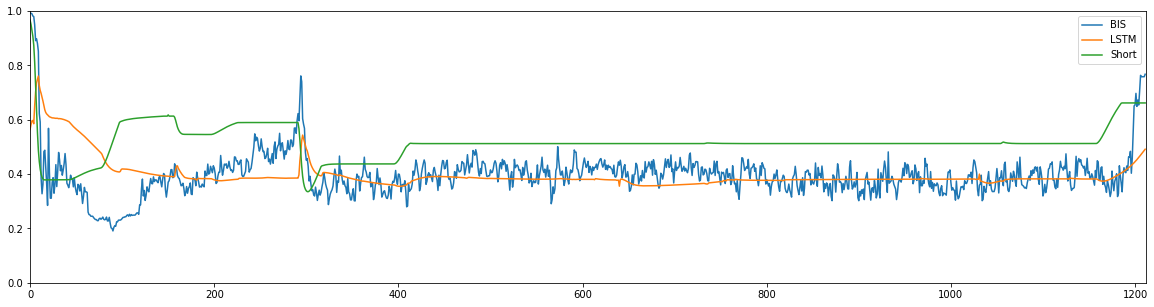

CaseID 6190, LSTM MAPE=18.50294303894043, Short MAPE=19.429122924804688


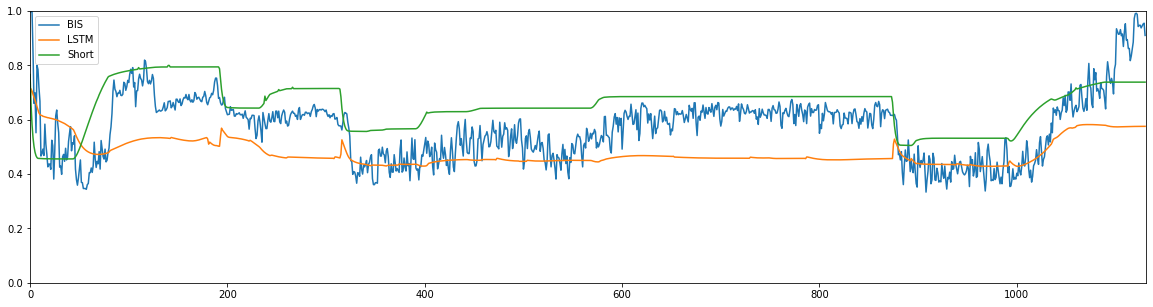

CaseID 6223, LSTM MAPE=35.24201202392578, Short MAPE=54.83167266845703


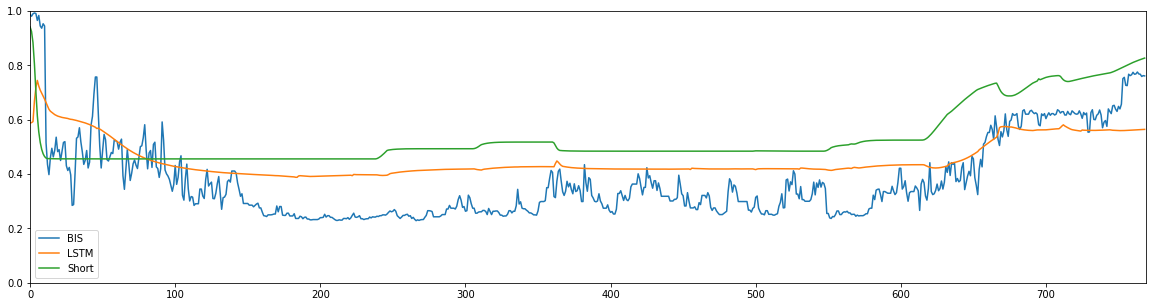

CaseID 6304, LSTM MAPE=15.461540222167969, Short MAPE=16.66444206237793


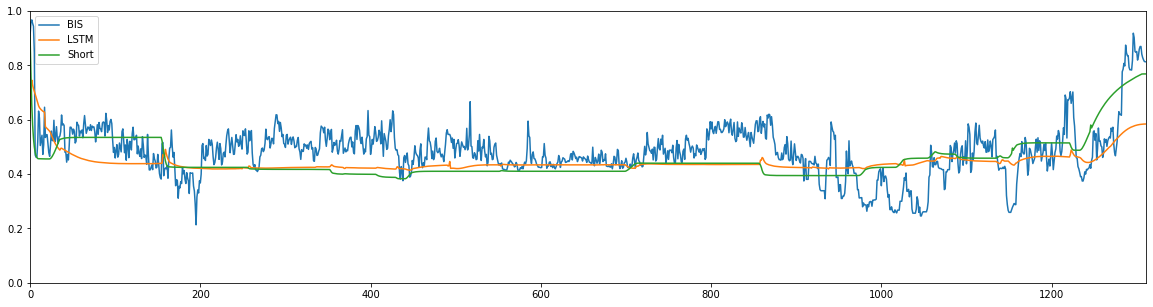

CaseID 6311, LSTM MAPE=10.68997573852539, Short MAPE=37.38684844970703


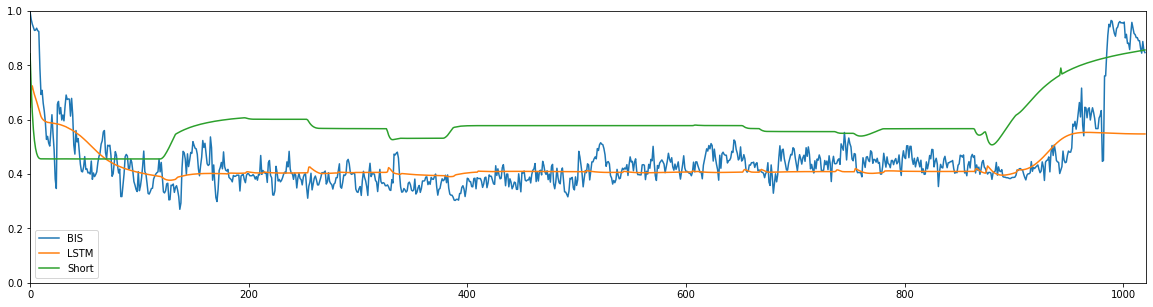

In [30]:
# 예측
y_pred = model.predict(x_test).flatten()
print("Test MAPE: {}".format(mape(y_test, y_pred)))

# 각 case에서 예측 결과를 그림으로 확인
import matplotlib.pyplot as plt
for caseid in test_caseids:
    case_mask = (x_caseid[test_mask] == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    print('CaseID {}, LSTM MAPE={}, Short MAPE={}'.format(caseid, 
      mape(y_test[case_mask], y_pred[case_mask]), 
      mape(y_test[case_mask], y_old[case_mask])
      ))

    t = np.arange(0, case_len)
    plt.figure(figsize=(20, 5))
    plt.plot(t, y_test[case_mask], label='BIS')  # 측정 결과
    plt.plot(t, y_pred[case_mask], label='LSTM')  # LSTM model
    plt.plot(t, y_old[case_mask], label='Short')  # Short model
    plt.legend()
    plt.xlim([0, case_len])
    plt.ylim([0, 1])
    plt.show()